# Data Cleaning and modeling

In [210]:
## Import libraries
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re

import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB ,GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import warnings

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# Set to ignore any warnings
warnings.filterwarnings('ignore')

In [211]:
## load training data
df= pd.read_csv("train.csv")

In [212]:
df.index = df['id']

In [213]:
# Drop column 'id'
data = df.drop(columns = ['id'])

In [214]:
data.reset_index(inplace= True)

In [215]:
# Drop column 'id'
data = data.drop(columns = ['id'])

In [216]:
data.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [217]:
keywords = []
for i in data['keyword'].values:
    keywords.append(re.sub(r'%20', ' ', str(i)))

In [218]:
data['keyword'] = keywords

In [219]:
data.head()  ## display the 1st 10 rows of the dataframe

,keyword,location,text,target
0,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,nan,NaN,Forest fire near La Ronge Sask. Canada,1
2,nan,NaN,All residents asked to 'shelter in place' are ...,1
3,nan,NaN,"13,000 people receive #wildfires evacuation or...",1
4,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Removing unncesaray words from text

In [325]:
text = pd.Series(data['text'])

In [326]:
# Remove the unnecessary pattern starting from Û
new_text = []
for j in range(len(text)):
    result = re.sub(r'\b[Û\\n]\w*\b', '', text[j])
    new_text.append(result)

In [327]:
## Remove urls
new_text_1 = []
for j in range(len(new_text)):
    result = re.sub(r'http[s]?://\S+', '', new_text[j])
    new_text_1.append(result)

In [328]:
## Remove non-english 
new_text_2 = []
for j in range(len(new_text_1)):
    result = re.sub(r'[^\x00-\x7F]+', '', new_text_1[j])
    new_text_2.append(result)

In [329]:
data['text']=new_text_2

In [330]:
data = data.loc[:,['text','target']]

In [331]:
data.head(8)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1


In [332]:
#define X,y 
X= pd.Series(data['text'])
y = data['target']

In [227]:
#Data size
X.shape, y.shape

((7613,), (7613,))

In [228]:
#check the baseline score
y.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

# Plot the word cloud

In [229]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [230]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

# list of english stopwords
stop_words = set(stopwords.words('english'))

#Removing stopwords
cvec.set_params(stop_words=list(stop_words))

# Transform the corpus.
X_train_cv = cvec.fit_transform(X_train)
X_test_cv = cvec.transform(X_test)

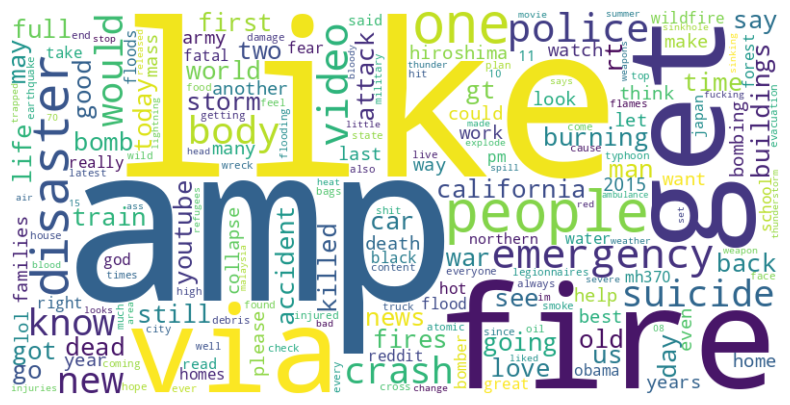

In [279]:
# Convert X_train into a DataFrame.
X_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names_out())

# Convert the feature names and their counts into a dictionary
word_frequency = dict(zip(cvec.get_feature_names_out(), X_df.sum(axis=0)))

# Create a WordCloud object
wc = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud 
wc.generate_from_frequencies(word_frequency)

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')

plt.axis('off')
plt.show()

In [232]:
# Train test split again for modeling
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2020)

# The Models used here for testing:

---

- LogisticRegressionCV
- RandomForestClassifier
- KNN Classifier
- BernoulliNB
- Support Vector Machine Classifier

# LogisticRegressionCV

In [233]:
# Let's set a pipeline up with two stages:
pipe_logr = Pipeline([
    ('vec', CountVectorizer()),
    ('logr', LogisticRegressionCV(max_iter=5000,solver = 'lbfgs'))
])

In [234]:
pipe_params_logr = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [5000],
    'vec__min_df' : [5],#[3,5]
    'vec__max_df' : [0.9],#0.95],
    'vec__ngram_range' : [(1,2)],#(1,1)],
    'vec__stop_words' : [ None, 'english']
}

In [235]:
# Instantiate GridSearchCV for LogisticRegressionCV
gs_logr = GridSearchCV(pipe_logr,     # what object are we optimizing?
                  pipe_params_logr,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [236]:
# Fit GridSearch to training data.
gs_logr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(max_iter=5000))]),
             param_grid={'vec': [CountVectorizer(),
                                 TfidfVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=5,
                                                 ngram_range=(1, 2))],
                         'vec__max_df': [0.9], 'vec__max_features': [5000],
                         'vec__min_df': [5], 'vec__ngram_range': [(1, 2)],
                         'vec__stop_words': [None, 'english']})

In [237]:
gs_logr.best_params_

{'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=5, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [238]:
# Get predictions
preds_logr = gs_logr.predict(X_test)

In [287]:
def evaluation(name_of_the_model ,y_test,preds,gs_model):
    ## find the confusion matrix
    cm = confusion_matrix(y_test,preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Accuracy, Sensitivity, Specificity, and Precision

    Sensitivity = round(tp/(tp+fn),3)
    Specificity = round(tn/(tn+fp),3)
    Precision = round(tp / (tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test,y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' :name_of_the_model,
        'Score on train':train_score ,
        'Score on test': test_score,
         'Sensitivity':Sensitivity,
         'Specificity':Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

In [288]:
logr = evaluation('logr',y_test,preds_logr,gs_logr)
logr

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,logr,0.837,0.791,0.648,0.905,0.844,0.733


# RandomForestClassifier

In [345]:
# Define the pipeline with FeatureUnion
pipe_rfc = Pipeline([
    ('vec',CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [349]:
# Set parameters for each vectorizer
pipe_params_rfc = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features': [5000],
    'vec__min_df': [5],
    'vec__max_df': [0.9],
    'vec__ngram_range': [(1, 2)],
    'vec__stop_words': [None, 'english'],
    'rfc__n_estimators': [50, 100, 200],          
    'rfc__max_depth': [None, 10, 20, 30],      
    'rfc__min_samples_split': [2, 5, 10],        
    'rfc__min_samples_leaf': [1, 2, 4],       
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__bootstrap': [True, False]  
}

In [350]:
# Instantiate GridSearchCV for RandomForestClassifier
gs_rfc = GridSearchCV(pipe_rfc,     # what object are we optimizing?
                  pipe_params_rfc,   # what parameters values are we searching?
                  cv=5)   

In [351]:
# Fit GridSearch to training data.
gs_rfc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__bootstrap': [True, False],
                         'rfc__max_depth': [None, 10, 20, 30],
                         'rfc__max_features': ['auto', 'sqrt', 'log2'],
                         'rfc__min_samples_leaf': [1, 2, 4],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [50, 100, 200],
                         'vec': [CountVectorizer(),
                                 TfidfVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=5,
                                                 ngram_range=(1, 2))],
                         'vec__max_df': [0.9], 'vec__max_features': [5000],
                         'vec__min_df': [5], 'vec__ngram_range': [(1, 2)],
                         'vec__stop_words': [None, 'english']})

In [352]:
gs_rfc.best_params_

{'rfc__bootstrap': False,
 'rfc__max_depth': None,
 'rfc__max_features': 'log2',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 100,
 'vec': TfidfVectorizer(max_df=0.9, max_features=5000, min_df=5, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [353]:
# Get predictions
preds_rfc = gs_rfc.predict(X_test)

In [354]:
Randomfc=evaluation('Randomfc',y_test,preds_rfc,gs_rfc)
Randomfc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Randomfc,0.915,0.806,0.666,0.916,0.863,0.752


# KNN Classifier

In [355]:
# Let's set a pipeline up with two stages:
pipe_knn = Pipeline([
    ('vec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [356]:
pipe_params_knn = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [5000],
    'vec__min_df' : [3,5],
    'vec__max_df' : [0.9,0.95],
    'vec__ngram_range' : [(1,1),(1,2)],
    'vec__stop_words' : [ None, 'english'],
    'knn__n_neighbors' : [3]
}

In [357]:
# Instantiate GridSearchCV for KNN Classifier
gs_knn = GridSearchCV(pipe_knn,     # what object are we optimizing?
                  pipe_params_knn,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [358]:
# Fit GridSearch to training data.
gs_knn.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3],
                         'vec': [CountVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=5, ngram_range=(1, 2),
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9, 0.95],
                         'vec__max_features': [5000], 'vec__min_df': [3, 5],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': [None, 'english']})

In [359]:
gs_knn.best_params_

{'knn__n_neighbors': 3,
 'vec': CountVectorizer(max_df=0.9, max_features=5000, min_df=5, ngram_range=(1, 2),
                 stop_words='english'),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': 'english'}

In [360]:
# Get predictions
preds_knn = gs_knn.predict(X_test)

In [361]:
knn = evaluation('KNN',y_test,preds_knn,gs_knn)
knn

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,KNN,0.826,0.713,0.463,0.912,0.806,0.588


# BernoulliNB

In [362]:
# Let's set a pipeline up with two stages:
pipe_bnb = Pipeline([
    ('vec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [363]:
pipe_params_bnb = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [5000],#2000, 3000, 4000, 5000],
    'vec__min_df' : [3,5],
    'vec__max_df' : [0.9,0.95],
    'vec__ngram_range' : [(1,1),(1,2)],
    'vec__stop_words' : [ None, 'english']
}

In [364]:
# Instantiate GridSearchCV for BernoulliNB
gs_bnb = GridSearchCV(pipe_bnb,     # what object are we optimizing?
                  pipe_params_bnb,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [365]:
# Fit GridSearch to training data.
gs_bnb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'vec': [CountVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=3),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9, 0.95],
                         'vec__max_features': [5000], 'vec__min_df': [3, 5],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': [None, 'english']})

In [366]:
gs_bnb.best_params_

{'vec': CountVectorizer(max_df=0.9, max_features=5000, min_df=3),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': None}

In [367]:
# Get predictions
preds_bnb = gs_bnb.predict(X_test)

In [368]:
bnb=evaluation('BernoulliNB',y_test,preds_bnb,gs_bnb)
bnb

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,BernoulliNB,0.854,0.808,0.697,0.896,0.842,0.763


In [369]:
# Let's set a pipeline up with two stages:
pipe_svc = Pipeline([
    ('vec', CountVectorizer()),
    ('svc', LinearSVC())
])

In [370]:
pipe_params_svc = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [4000],#2000, 3000, 4000, 5000],
    'vec__min_df' : [5],#[3,5]
    'vec__max_df' : [0.9],#[0.9,0.95]
    'vec__ngram_range' : [(1,2)],#[(1,1),(1,2)]
    'vec__stop_words' : [ None, 'english'],
    'svc__C' : np.linspace(0.0001, 1, 5)
}

In [371]:
# Instantiate GridSearchCV for LinearSVC
gs_svc = GridSearchCV(pipe_svc,     # what object are we optimizing?
                  pipe_params_svc,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [372]:
# Fit GridSearch to training data.
gs_svc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('svc', LinearSVC())]),
             param_grid={'svc__C': array([1.00000e-04, 2.50075e-01, 5.00050e-01, 7.50025e-01, 1.00000e+00]),
                         'vec': [CountVectorizer(),
                                 TfidfVectorizer(max_df=0.9, max_features=4000,
                                                 min_df=5,
                                                 ngram_range=(1, 2))],
                         'vec__max_df': [0.9], 'vec__max_features': [4000],
                         'vec__min_df': [5], 'vec__ngram_range': [(1, 2)],
                         'vec__stop_words': [None, 'english']})

In [373]:
gs_svc.best_params_

{'svc__C': 0.250075,
 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=5, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': 4000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [374]:
# Get predictions
preds_svc = gs_svc.predict(X_test)

In [375]:
svc = evaluation('LinearSVC',y_test,preds_svc,gs_svc)
svc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,LinearSVC,0.886,0.809,0.723,0.878,0.824,0.77


## Comparing all the models

In [376]:
Table = pd.concat([logr,Randomfc,knn,bnb,svc],ignore_index=True)

In [377]:
Table.set_index('Model')

,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
Model,,,,,,
logr,0.837,0.791,0.648,0.905,0.844,0.733
Randomfc,0.915,0.806,0.666,0.916,0.863,0.752
KNN,0.826,0.713,0.463,0.912,0.806,0.588
BernoulliNB,0.854,0.808,0.697,0.896,0.842,0.763
LinearSVC,0.886,0.809,0.723,0.878,0.824,0.770
